Pytorch is easier to debug, I like it.

TODO:
- [x] prioritised experience replay, need to grab loss for each sample, and sample based on loss
- [ ] check it for my data, can it overfit?, does the normalisation make sense?
- [x] better metrics
- [ ] do cnn model
- [x] read papers
- [ ] check i'm prioristising by the right things, should lead to lowest loss
- [ ] test on cartpole

Refs: 
- implementations:
    - PPO
        - **pytorch implementation https://github.com/alexis-jacq/Pytorch-DPPO/blob/master/ppo.py**
        - tensorflow implementation https://github.com/reinforceio/tensorforce/blob/master/tensorforce/models/ppo_model.py
    - Prioritised memory
    - Other
        - http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training
        - https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py
- papers:
    - DPPO https://arxiv.org/pdf/1707.02286.pdf
    - PPO 
        - https://arxiv.org/abs/1707.06347
        - https://blog.openai.com/openai-baselines-ppo/
    - TRPO https://arxiv.org/abs/1502.05477

In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime
import random

from collections import OrderedDict
from IPython.display import display
from pprint import pprint

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import argparse
import os
import sys
import gym
from gym import wrappers
import random
import numpy as np

import torch
import torch.optim as optim
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [4]:
class Params():
    def __init__(self):
        # env
        self.window_length = 50
        # Model
        self.batch_size = 250
        self.lr = 3e-4
        self.gamma = 0.00
        self.gae_param = 0.95
        self.clip = 0.2 # epsilon from eq 7, default 0.2
        self.ent_coeff = 0.
        self.num_epoch = 10
        self.num_steps = 2048
        self.time_horizon = 2000000
        self.max_episode_length = 10000
        self.seed = 1

params = Params()

save_path= 'outputs/agent_portfolio-ddpo/{}_seperate_weights.pickle'.format('2017-07-21')
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass
save_path

'outputs/agent_portfolio-ddpo/2017-07-21_seperate_weights.pickle'

# Memory
refs
- https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
- https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py

In [5]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, events):
        for event in zip(*events):
            self.memory.append(event)
            if len(self.memory)>self.capacity:
                del self.memory[0]

    def clear(self):
        self.memory = []

    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: torch.cat(x, 0), samples)

In [6]:
import torch.utils.data.sampler

class PrioritisedReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, events):
        # event is [states, actions, returns, advantages]
        # [1x3x5x50,1x6,1x1,1x1]
        for event in zip(*events):
            self.memory.append(event)
            if len(self.memory)>self.capacity:
                del self.memory[0]

    def clear(self):
        self.memory = []

    def sample(self, batch_size, beta=0.5):
        """
        Take a weighted sample based on advantages.
        
        Half hearted implementation of algorithm 1 from https://arxiv.org/pdf/1511.05952.pdf
        
        Better one here https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py#L157
        
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - minimal corrections, 1 - full correction)
            
        Returns
        ----------
        states
        actions
        returns
        advantages
        
        """
        # Sample transition
        # we want to minimise loss so
        #     weights ~ -loss (bigger the weight when the loss is lower)
        # and
        #     loss ~= -batch_advantages
        # so 
        #     weights ~ batch_advantages
        ps1 = torch.FloatTensor([m[-1].squeeze().data[0] for m in self.memory])        
        ps1 -= ps1.min()
        ps1 /= ps1.sum()
        
        # batch_returns
#         ps2 = torch.FloatTensor([m[-2].squeeze().data[0] for m in self.memory])             
#         ps2 -= ps2.min()
#         ps2 /= ps2.sum()
        
        ps = ps1#-ps2 # priority        
        ps -= ps.min() - 1.0
        P = ps/ps.sum() # normalize
        
        # Compute importance-sampling weight
        P = (len(P) * P) ** (-beta)
        w = P / P.max()
        
        # to list and remove nans
        w = w.numpy()
#         w[np.isfinite(w)==False] = 0
        w = w.tolist()
        
        idxs = torch.utils.data.sampler.WeightedRandomSampler(w, params.batch_size, replacement=False)
        
        # concatenate it into batches
        samples = zip(*[self.memory[n] for n in idxs])        
        return map(lambda x: torch.cat(x, 0), samples)

In [7]:
# # Test by making sure the sample has a higher returns than the mean
# batch_states, batch_actions, batch_returns, batch_advantages = memory.sample(200)

# ps1 = torch.FloatTensor([m[-1].squeeze().data[0] for m in memory.memory])        
# print(batch_advantages.mean(),ps1.mean())
# assert batch_advantages.mean().data[0]>ps1.mean()

# # ps2 = torch.FloatTensor([m[-2].squeeze().data[0] for m in memory.memory]) 
# # assert batch_returns.mean().data[0]>ps2.mean()


# Enviroment

In [8]:
from src.environments.portfolio import PortfolioEnv, sharpe, max_drawdown

# we want to pemute the channels a little

class PermutedPortfolioEnv(PortfolioEnv):
    def reset(self, *args, **kwargs):
        return np.transpose(super().reset(*args, **kwargs),(0,1,2))
    def step(self, *args, **kwargs):
        observation, reward, done, info = super().step(*args, **kwargs)
        observation = np.transpose(observation,(2,0,1))
        return observation, reward, done, info


df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = PermutedPortfolioEnv(
    df=df_train,
    steps=128, 
    scale=True, 
    augment=0.00025, # let just overfit first,
    trading_cost=0, #0.0025, # let just overfit first,
    window_length = params.window_length,   
)
env.seed(params.seed)
env.reset().shape

df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PermutedPortfolioEnv(
    df=df_test,
    steps=128, 
    scale=True, 
    augment=0.00025, # let just overfit first,
    trading_cost=0, #0.0025, # let just overfit first,
    window_length = params.window_length,   
)
env_test.seed(params.seed)
env_test.reset().shape

(3, 5, 50)

# Model

In [10]:
class GenericSharedModel(nn.Module):
    def __init__(self, inputs, outputs):
        super(GenericSharedModel, self).__init__()
        num_inputs = int(np.prod(env.observation_space.shape))
        num_outputs = int(np.prod(env.action_space.shape))
        
        # hidden layer sizes
        h_size_1 = 128
        h_size_2 = 128
        
        self.conv1 = nn.Conv2d(3, 2, (1, 3))
        self.conv2 = nn.Conv2d(2, 20, (1, inputs[1] - 2))
        
        self.fc1 = nn.Linear(num_inputs, h_size_1)
        self.fc2 = nn.Linear(h_size_1, h_size_2)
        
        self.mu = nn.Linear(h_size_2, num_outputs)
        self.log_std = nn.Parameter(torch.zeros(num_outputs))
        
        
        self.fc1b = nn.Linear(num_inputs, h_size_1)
        self.fc2b = nn.Linear(h_size_1, h_size_2)
        
        self.v = nn.Linear(h_size_2,1)
        
        for name, p in self.named_parameters():
            # init parameters
            if 'bias' in name:
                p.data.fill_(0)
            '''
            if 'mu.weight' in name:
                p.data.normal_()
                p.data /= torch.sum(p.data**2,0).expand_as(p.data)'''
        
        # mode
        self.train()

    def forward(self, inputs):
        # flatten
        inputs = inputs.view((inputs.size()[0],-1))
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        h = x.view(x.size(0),-1) # Flatten
        
        # actor
        x = F.tanh(self.fc1(h))
        x = F.tanh(self.fc2(x))
        
        # the action
        mu = F.softmax(self.mu(x))
        
        # exploration multiplier
        log_std = F.sigmoid(torch.exp(self.log_std).unsqueeze(0).expand_as(mu))
        
        # critic
        x = F.tanh(self.fc1(h))
        x = F.tanh(self.fc2(x))
        v = self.v(x)
        return mu, log_std, v

# Train

In [11]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [12]:

# class Shared_grad_buffers():
#     def __init__(self, model):
#         self.grads = {}
#         for name, p in model.named_parameters():
#             self.grads[name+'_grad'] = torch.ones(p.size()).share_memory_()

#     def add_gradient(self, model):
#         for name, p in model.named_parameters():
#             self.grads[name+'_grad'] += p.grad.data

#     def reset(self):
#         for name,grad in self.grads.items():
#             self.grads[name].fill_(0)

class Shared_obs_stats():
    """Like batchnorm for input data"""
    def __init__(self, num_inputs):
        self.n = torch.zeros(num_inputs).share_memory_()
        self.mean = torch.zeros(num_inputs).share_memory_()
        self.mean_diff = torch.zeros(num_inputs).share_memory_()
        self.var = torch.zeros(num_inputs).share_memory_()

    def observes(self, obs):
        # observation mean var updates
        x = obs.data.squeeze()
        self.n += 1.
        last_mean = self.mean.clone()
        self.mean += (x-self.mean)/self.n
        self.mean_diff += (x-last_mean)*(x-self.mean)
        self.var = torch.clamp(self.mean_diff/self.n, min=1e-2)

    def normalize(self, inputs):
        obs_mean = Variable(self.mean.unsqueeze(0).expand_as(inputs))
        obs_std = Variable(torch.sqrt(self.var).unsqueeze(0).expand_as(inputs))
        return torch.clamp((inputs-obs_mean)/obs_std, -5., 5.)

In [13]:
def normal(x, mu, sigma_sq):
    a = (-1*(x-mu).pow(2)/(2*sigma_sq)).exp()
    b = 1/(2*sigma_sq*np.pi).sqrt()
    return a*b

In [14]:

cuda = False
torch.manual_seed(params.seed)
work_dir = mkdir('exp', 'ppo')
monitor_dir = mkdir(work_dir, 'monitor')

# env = gym.make(params.env_name)
#env = wrappers.Monitor(env, monitor_dir, force=True)

num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.shape[0]


#initialize network and optimizer
Model = GenericSharedModel
Model = EIIE_CNN
model = Model(env.observation_space.shape, env.action_space.shape)
if cuda: model.cuda()

# shared_obs_stats = Shared_obs_stats(num_inputs)
optimizer = optim.Adam(model.parameters(), lr=params.lr)
model

EIIE_CNN (
  (conv1): Conv2d(3, 2, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(2, 20, kernel_size=(1, 48), stride=(1, 1))
  (conv3): Conv2d(20, 1, kernel_size=(1, 1), stride=(1, 1))
  (head): Linear (5 -> 6)
  (conv2b): Conv2d(2, 20, kernel_size=(1, 48), stride=(1, 1))
  (conv3b): Conv2d(20, 1, kernel_size=(1, 1), stride=(1, 1))
  (headb): Linear (5 -> 6)
  (v): Linear (6 -> 1)
)

In [15]:
memory = ReplayMemory(params.num_steps)
# memory = PrioritisedReplayMemory(params.num_steps)

num_inputs = int(np.prod(env.observation_space.shape))
num_outputs = int(np.prod(env.action_space.shape))

state = env.reset()
state = Variable(torch.Tensor(state).unsqueeze(0))
done = True
episode_length = 0
reports = []

with tqdm(total=params.time_horizon, mininterval=2, unit='steps') as p:
    episode = -1    
    steps = 0
    # horizon loop
    while steps < params.time_horizon:
        infos = []
        episode_length = 0
        # Sample data from the policy
        while (len(memory.memory) < params.num_steps):
            states = []
            actions = []
            rewards = []
            values = []
            returns = []
            advantages = []
            av_reward = 0
            cum_reward = 0
            cum_done = 0
            # n steps loops
            for step in range(params.num_steps):
                #                 shared_obs_stats.observes(state)
                #                 state = shared_obs_stats.normalize(state)
                states.append(state)
                
                mu, sigma_sq, v = model(state)
                eps = torch.randn(mu.size())
                action = (mu + sigma_sq.sqrt() * Variable(eps))
                env_action = action.data.squeeze().numpy()
                state, reward, done, info = env.step(env_action)
                done = (done or episode_length >= params.max_episode_length)
                
                cum_reward += reward
                reward = max(min(reward, 1), -1)
                rewards.append(reward)
                actions.append(action)
                values.append(v)
                
                steps+=1  
                p.update(1)
                if done:
                    episode += 1
                    cum_done += 1
                    av_reward += cum_reward
                    p.desc='av_reward={: 2.8f}'.format(av_reward / float(cum_done))
                    cum_reward = 0
                    episode_length = 0
                    infos.append(info)
                    state = env.reset()
                
                state = Variable(torch.Tensor(state).unsqueeze(0))
                
                if done:
                    break
            
            # one last step
            R = torch.zeros(1, 1)
            if not done:
                _, _, v = model(state)
                R = v.data
            
            # compute returns and GAE(lambda) advantages:
            values.append(Variable(R))
            R = Variable(R)
            A = Variable(torch.zeros(1, 1))
            for i in reversed(range(len(rewards))):
                td = rewards[i] + params.gamma*values[i+1].data[0,0] - values[i].data[0,0]
                A = float(td) + params.gamma * params.gae_param * A
                advantages.insert(0, A)
                R = A + values[i]
                returns.insert(0, R)
            
            # store useful info:
            memory.push([states, actions, returns, advantages])
            

        # perform several epochs of optimization on the sampled data
        model_old = Model(env.observation_space.shape,
                             env.action_space.shape)
        model_old.load_state_dict(model.state_dict())
        av_loss = 0
        for k in range(params.num_epoch):
            # cf https://github.com/openai/baselines/blob/master/baselines/pposgd/pposgd_simple.py
            batch_states, batch_actions, batch_returns, batch_advantages = memory.sample(
                params.batch_size)
            
            # old probas
            mu_old, sigma_sq_old, v_pred_old = model_old(batch_states.detach())
            probs_old = normal(batch_actions, mu_old, sigma_sq_old)
            
            # new probas
            mu, sigma_sq, v_pred = model(batch_states)
            probs = normal(batch_actions, mu, sigma_sq)
            
            # ratio
            ratio = probs / (1e-15 + probs_old)
            
            # surrogate clip loss
            surr1 = ratio * torch.cat([batch_advantages]*num_outputs,1) # surrogate from conservative policy iteration
            surr2 = ratio.clamp(1-params.clip, 1+params.clip) * torch.cat([batch_advantages]*num_outputs,1)
            loss_clip = -torch.mean(torch.min(surr1, surr2))
            # should this be a mean along axis 0?
            
            # state-value function loss, do we even need this if they don't share params?
            vfloss1 = (v_pred - batch_returns)**2
            v_pred_clipped = v_pred_old + (v_pred - v_pred_old).clamp(-params.clip, params.clip)
            vfloss2 = (v_pred_clipped - batch_returns)**2
            loss_value = 0.5 * torch.mean(torch.max(vfloss1, vfloss2))
            # should this be a mean along axis 0?
            
            # loss on entropy bonus to ensure sufficient exploration
            loss_ent = -params.ent_coeff*torch.mean(probs*torch.log(probs+1e-5))
            
            # total
            total_loss = (loss_clip + loss_value + loss_ent)
#             total_loss = (loss_clip - loss_value + loss_ent)
            av_loss += loss_value.data[0] / float(params.num_epoch)
            
            # before step, update old_model:
            model_old.load_state_dict(model.state_dict())
            
            # step
            optimizer.zero_grad()
            total_loss.backward(retain_variables=True)
            optimizer.step()
        
        # t finish, print:
        df_infos = pd.DataFrame(infos)
        
        # show stats?
#         display(df_infos[["cash_bias","return","portfolio_value","market_value"]].describe().loc[["min","mean","max"]])
        
        report=OrderedDict(
            episode=episode,
#             reward=av_reward / float(cum_done),
            loss=av_loss,
            cash_bias=df_infos.cash_bias.mean(),
            market_value=df_infos.market_value.mean(),
            portfolio_value=df_infos.portfolio_value.mean(),
            reward=df_infos.reward.mean()
        )
        
        s = ', '.join(['{}={:2.4g}'.format(key,value) for key,value in report.items()])
        print(s)
        
        reports.append(report)
        
        memory.clear()
        torch.save(model_old, save_path)


portfolio_value=1.049, cash_bias=0.3195, market_value=1.025, reward=1.138e-05, episode=15, loss=0.000261


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type EIIE_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


portfolio_value=1.073, cash_bias=0.157, market_value=1.048, reward=4.855e-06, episode=31, loss=0.0002609
portfolio_value=1.061, cash_bias=0.2, market_value=1.029, reward=-2.669e-05, episode=47, loss=0.000261
portfolio_value=1.042, cash_bias=0.295, market_value=1.03, reward=1.347e-05, episode=63, loss=0.0002603
portfolio_value=1.08, cash_bias=0.2887, market_value=1.066, reward=-1.589e-06, episode=79, loss=0.0002598
portfolio_value=1.005, cash_bias=0.2187, market_value=1.039, reward=-2.089e-05, episode=95, loss=0.0002598
portfolio_value=1.041, cash_bias=0.2338, market_value=1.057, reward=3.306e-05, episode=111, loss=0.0002597
portfolio_value=1.079, cash_bias=0.2115, market_value=1.035, reward=2.707e-05, episode=127, loss=0.0002596
portfolio_value=1.052, cash_bias=0.2053, market_value=1.03, reward=4.84e-06, episode=143, loss=0.0002596
portfolio_value=1.054, cash_bias=0.2824, market_value=1.069, reward=3.712e-06, episode=159, loss=0.0002596
portfolio_value=1.031, cash_bias=0.2244, market_v

portfolio_value=1.007, cash_bias=0.2388, market_value=1.022, reward=-2.415e-05, episode=1263, loss=0.0002598
portfolio_value=1.04, cash_bias=0.3485, market_value=1.05, reward=7.861e-06, episode=1279, loss=0.0002596
portfolio_value=1.016, cash_bias=0.2901, market_value=1.054, reward=-6.921e-06, episode=1295, loss=0.0002597
portfolio_value=1.064, cash_bias=0.2432, market_value=1.036, reward=1.058e-05, episode=1311, loss=0.0002596
portfolio_value=1.026, cash_bias=0.342, market_value=0.9962, reward=-2.477e-05, episode=1327, loss=0.0002597
portfolio_value=0.999, cash_bias=0.3548, market_value=1.017, reward=1.143e-05, episode=1343, loss=0.0002597
portfolio_value=1.083, cash_bias=0.3556, market_value=1.067, reward=4.655e-05, episode=1359, loss=0.0002596
portfolio_value=0.9973, cash_bias=0.212, market_value=1.014, reward=-1.284e-05, episode=1375, loss=0.0002597
portfolio_value=1.02, cash_bias=0.4374, market_value=1.038, reward=-8.869e-06, episode=1391, loss=0.0002597
portfolio_value=1.05, cash

portfolio_value=1.082, cash_bias=0.2483, market_value=1.049, reward=-4.433e-06, episode=2479, loss=0.0002596
portfolio_value=1.077, cash_bias=0.1755, market_value=1.045, reward=2.396e-05, episode=2495, loss=0.0002597
portfolio_value=1.054, cash_bias=0.1596, market_value=1.034, reward=6.848e-06, episode=2511, loss=0.0002597
portfolio_value=0.9937, cash_bias=0.2124, market_value=1.021, reward=1.722e-06, episode=2527, loss=0.0002598
portfolio_value=1.022, cash_bias=0.2606, market_value=1.013, reward=1.049e-05, episode=2543, loss=0.0002597
portfolio_value=1.037, cash_bias=0.3168, market_value=1.039, reward=-1.62e-05, episode=2559, loss=0.0002597
portfolio_value=1.028, cash_bias=0.1606, market_value=1.03, reward=1.206e-05, episode=2575, loss=0.0002596
portfolio_value=1.035, cash_bias=0.1901, market_value=1.029, reward=-6.543e-06, episode=2591, loss=0.0002597
portfolio_value=1.044, cash_bias=0.1994, market_value=1.027, reward=-5.397e-06, episode=2607, loss=0.0002597
portfolio_value=1.047, ca

portfolio_value=1.04, cash_bias=0.2597, market_value=1.037, reward=-1.03e-05, episode=3695, loss=0.0002427
portfolio_value=0.9749, cash_bias=0.2041, market_value=1.004, reward=-1.762e-05, episode=3711, loss=0.0002428
portfolio_value=1.055, cash_bias=0.1816, market_value=1.049, reward=-2.367e-05, episode=3727, loss=0.0002432
portfolio_value=1.015, cash_bias=0.2677, market_value=1.011, reward=9.779e-06, episode=3743, loss=0.0002444
portfolio_value=1.015, cash_bias=0.2185, market_value=1.029, reward=2.224e-05, episode=3759, loss=0.0002457
portfolio_value=0.9814, cash_bias=0.3043, market_value=1.02, reward=-6.094e-05, episode=3775, loss=0.0002461
portfolio_value=1.069, cash_bias=0.3345, market_value=1.039, reward=-3.511e-05, episode=3791, loss=0.0002462
portfolio_value=1.048, cash_bias=0.2425, market_value=1.027, reward=1.796e-05, episode=3807, loss=0.0002463
portfolio_value=1.023, cash_bias=0.2241, market_value=1.015, reward=-3.637e-06, episode=3823, loss=0.0002463
portfolio_value=1.039, 

portfolio_value=1.024, cash_bias=0.1079, market_value=1.051, reward=9.701e-06, episode=4911, loss=0.0002462
portfolio_value=1.033, cash_bias=0.2285, market_value=1.033, reward=1.263e-05, episode=4927, loss=0.0002463
portfolio_value=1.004, cash_bias=0.2767, market_value=1.017, reward=-3.689e-06, episode=4943, loss=0.0002463
portfolio_value=1.026, cash_bias=0.2327, market_value=1.047, reward=-2.401e-05, episode=4959, loss=0.0002463
portfolio_value=0.9764, cash_bias=0.2318, market_value=1.013, reward=6.315e-06, episode=4975, loss=0.0002464
portfolio_value=1.037, cash_bias=0.1843, market_value=1.051, reward=-1.967e-05, episode=4991, loss=0.0002463
portfolio_value=1.015, cash_bias=0.1762, market_value=1.024, reward=-2.799e-05, episode=5007, loss=0.0002463
portfolio_value=1.034, cash_bias=0.3465, market_value=1.039, reward=-2.289e-05, episode=5023, loss=0.0002463
portfolio_value=1.049, cash_bias=0.1002, market_value=1.037, reward=1.723e-05, episode=5039, loss=0.0002462
portfolio_value=1.086,

portfolio_value=1.032, cash_bias=0.3458, market_value=1.06, reward=-3.472e-05, episode=6127, loss=0.0002463
portfolio_value=1.021, cash_bias=0.2263, market_value=1.031, reward=3.84e-05, episode=6143, loss=0.0002463
portfolio_value=1.058, cash_bias=0.2469, market_value=1.068, reward=8.301e-06, episode=6159, loss=0.0002463
portfolio_value=1.021, cash_bias=0.3243, market_value=1.029, reward=-1.039e-05, episode=6175, loss=0.0002463
portfolio_value=1.054, cash_bias=0.2013, market_value=1.023, reward=-2.087e-05, episode=6191, loss=0.0002463
portfolio_value=1.067, cash_bias=0.3865, market_value=1.043, reward=1.301e-05, episode=6207, loss=0.0002462
portfolio_value=1.064, cash_bias=0.3071, market_value=1.065, reward=1.595e-06, episode=6223, loss=0.0002462
portfolio_value=1.011, cash_bias=0.2504, market_value=1.029, reward=-1.24e-05, episode=6239, loss=0.0002463
portfolio_value=1.021, cash_bias=0.1794, market_value=1.014, reward=-8.65e-06, episode=6255, loss=0.0002463
portfolio_value=1.027, cash

portfolio_value=1.008, cash_bias=0.3215, market_value=1.009, reward=-4.55e-06, episode=7343, loss=0.0002463
portfolio_value=1.057, cash_bias=0.3237, market_value=1.061, reward=1.097e-05, episode=7359, loss=0.0002463
portfolio_value=1.086, cash_bias=0.3549, market_value=1.053, reward=-4.186e-06, episode=7375, loss=0.0002463
portfolio_value=1.054, cash_bias=0.2391, market_value=1.027, reward=-1.189e-05, episode=7391, loss=0.0002462
portfolio_value=1.024, cash_bias=0.1439, market_value=1.022, reward=-2.281e-05, episode=7407, loss=0.0002463
portfolio_value=1.033, cash_bias=0.2965, market_value=1.042, reward=1.282e-05, episode=7423, loss=0.0002463
portfolio_value=1.048, cash_bias=0.2399, market_value=1.018, reward=1.411e-05, episode=7439, loss=0.0002463
portfolio_value=1.041, cash_bias=0.3339, market_value=1.038, reward=1.768e-06, episode=7455, loss=0.0002462
portfolio_value=1.057, cash_bias=0.2004, market_value=1.043, reward=-3.453e-05, episode=7471, loss=0.0002463
portfolio_value=1.017, c

portfolio_value=1.009, cash_bias=0.2558, market_value=1.016, reward=-4.616e-06, episode=8559, loss=0.0002463
portfolio_value=1.049, cash_bias=0.2429, market_value=1.032, reward=1.861e-06, episode=8575, loss=0.0002462
portfolio_value=1.026, cash_bias=0.1643, market_value=1.055, reward=-6.888e-06, episode=8591, loss=0.0002463
portfolio_value=1.053, cash_bias=0.2668, market_value=1.035, reward=-2.599e-05, episode=8607, loss=0.0002463
portfolio_value=0.9998, cash_bias=0.257, market_value=1.022, reward=6.93e-06, episode=8623, loss=0.0002464
portfolio_value=1.017, cash_bias=0.3561, market_value=1.039, reward=-1.859e-05, episode=8639, loss=0.0002463
portfolio_value=1.014, cash_bias=0.2465, market_value=1.015, reward=-8.17e-06, episode=8655, loss=0.0002463
portfolio_value=1.006, cash_bias=0.2388, market_value=1.006, reward=-1.792e-05, episode=8671, loss=0.0002463
portfolio_value=1.065, cash_bias=0.1173, market_value=1.031, reward=3.14e-07, episode=8687, loss=0.0002462
portfolio_value=1.057, ca

portfolio_value=1.011, cash_bias=0.2272, market_value=1.025, reward=1.072e-05, episode=9791, loss=0.0002481
portfolio_value=1.1, cash_bias=0.2078, market_value=1.067, reward=-9.594e-06, episode=9807, loss=0.000248
portfolio_value=1.049, cash_bias=0.1428, market_value=1.056, reward=2.568e-05, episode=9823, loss=0.000248
portfolio_value=1.004, cash_bias=0.3183, market_value=1.01, reward=1.008e-05, episode=9839, loss=0.0002481
portfolio_value=1.037, cash_bias=0.1731, market_value=1.034, reward=3.989e-05, episode=9855, loss=0.000248
portfolio_value=1.066, cash_bias=0.2188, market_value=1.043, reward=1.396e-05, episode=9871, loss=0.000248
portfolio_value=1.006, cash_bias=0.2059, market_value=1.026, reward=-1.016e-05, episode=9887, loss=0.0002481
portfolio_value=1.036, cash_bias=0.1549, market_value=1.028, reward=1.749e-05, episode=9903, loss=0.000248
portfolio_value=1.013, cash_bias=0.209, market_value=1.036, reward=1.165e-05, episode=9919, loss=0.0002481
portfolio_value=1.003, cash_bias=0.

portfolio_value=1.053, cash_bias=0.1108, market_value=1.061, reward=2.451e-05, episode=1.098e+04, loss=0.000248
portfolio_value=1.019, cash_bias=0.3001, market_value=1.033, reward=-1.077e-06, episode=1.099e+04, loss=0.0002481
portfolio_value=1.038, cash_bias=0.2384, market_value=1.035, reward=6.977e-06, episode=1.101e+04, loss=0.0002484
portfolio_value=1.038, cash_bias=0.224, market_value=1.027, reward=5.126e-05, episode=1.102e+04, loss=0.000248
portfolio_value=1.018, cash_bias=0.436, market_value=0.9977, reward=-3.495e-05, episode=1.104e+04, loss=0.000248
portfolio_value=1.022, cash_bias=0.1419, market_value=1.001, reward=-1.855e-05, episode=1.106e+04, loss=0.000248
portfolio_value=1.061, cash_bias=0.1943, market_value=1.029, reward=6.192e-06, episode=1.107e+04, loss=0.000248
portfolio_value=1.105, cash_bias=0.205, market_value=1.076, reward=2.679e-05, episode=1.109e+04, loss=0.000248
portfolio_value=1.042, cash_bias=0.153, market_value=1.043, reward=1.012e-05, episode=1.11e+04, loss=

portfolio_value=0.9962, cash_bias=0.2843, market_value=1.01, reward=-5.301e-06, episode=1.214e+04, loss=0.0002481
portfolio_value=1.094, cash_bias=0.3076, market_value=1.063, reward=2.911e-05, episode=1.216e+04, loss=0.000248
portfolio_value=1.053, cash_bias=0.2491, market_value=1.04, reward=1.138e-06, episode=1.218e+04, loss=0.000248
portfolio_value=1.063, cash_bias=0.2369, market_value=1.045, reward=1.51e-05, episode=1.219e+04, loss=0.0002481
portfolio_value=0.9863, cash_bias=0.1727, market_value=0.9976, reward=-1.552e-07, episode=1.221e+04, loss=0.0002481
portfolio_value=1.092, cash_bias=0.1192, market_value=1.043, reward=1.641e-05, episode=1.222e+04, loss=0.000248
portfolio_value=1.056, cash_bias=0.1317, market_value=1.042, reward=-8.997e-06, episode=1.224e+04, loss=0.000248
portfolio_value=1.03, cash_bias=0.1829, market_value=1.003, reward=5.396e-05, episode=1.226e+04, loss=0.0002481
portfolio_value=1.077, cash_bias=0.1794, market_value=1.031, reward=-6.247e-06, episode=1.227e+04,

portfolio_value=1.016, cash_bias=0.2811, market_value=1.027, reward=-2.855e-06, episode=1.331e+04, loss=0.000248
portfolio_value=1.019, cash_bias=0.1379, market_value=1.046, reward=-2.49e-05, episode=1.333e+04, loss=0.0002481
portfolio_value=1.051, cash_bias=0.2097, market_value=1.031, reward=-1.056e-05, episode=1.334e+04, loss=0.000248
portfolio_value=1.022, cash_bias=0.1302, market_value=1.002, reward=5.876e-06, episode=1.336e+04, loss=0.0002481
portfolio_value=1.013, cash_bias=0.2979, market_value=1.017, reward=-3.207e-06, episode=1.338e+04, loss=0.0002481
portfolio_value=1.052, cash_bias=0.3713, market_value=1.045, reward=2.158e-05, episode=1.339e+04, loss=0.000248
portfolio_value=1.01, cash_bias=0.2456, market_value=1.005, reward=4.504e-06, episode=1.341e+04, loss=0.0002482
portfolio_value=1.011, cash_bias=0.4574, market_value=1.009, reward=1.666e-05, episode=1.342e+04, loss=0.0002481
portfolio_value=1.035, cash_bias=0.2843, market_value=1.015, reward=9.034e-06, episode=1.344e+04,

portfolio_value=1.014, cash_bias=0.3171, market_value=1.009, reward=6.229e-06, episode=1.448e+04, loss=0.0002481
portfolio_value=1.023, cash_bias=0.1674, market_value=1.031, reward=9.427e-06, episode=1.45e+04, loss=0.0002481
portfolio_value=0.9927, cash_bias=0.2508, market_value=1.007, reward=-8.455e-08, episode=1.451e+04, loss=0.0002481
portfolio_value=1.034, cash_bias=0.208, market_value=1.022, reward=-2.309e-05, episode=1.453e+04, loss=0.000248
portfolio_value=1.031, cash_bias=0.167, market_value=1.045, reward=4.485e-06, episode=1.454e+04, loss=0.000248
portfolio_value=1.07, cash_bias=0.2217, market_value=1.039, reward=-1.757e-05, episode=1.456e+04, loss=0.000248
portfolio_value=1.037, cash_bias=0.2026, market_value=1.043, reward=1.725e-05, episode=1.458e+04, loss=0.000248
portfolio_value=1.042, cash_bias=0.1602, market_value=1.031, reward=1.916e-05, episode=1.459e+04, loss=0.0002481
portfolio_value=1.049, cash_bias=0.3001, market_value=1.016, reward=-2.504e-05, episode=1.461e+04, l

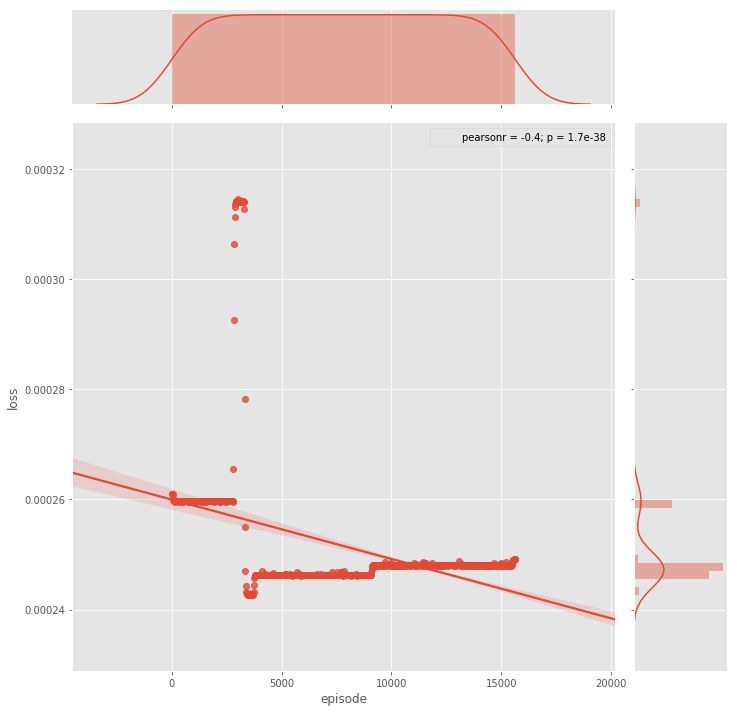

In [18]:
# show progress
df=pd.DataFrame(reports)
g = sns.jointplot(x="episode", y="loss", data=df, kind="reg", size=10)
plt.show()

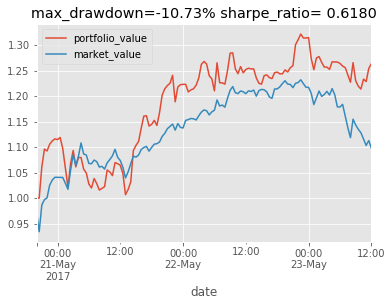

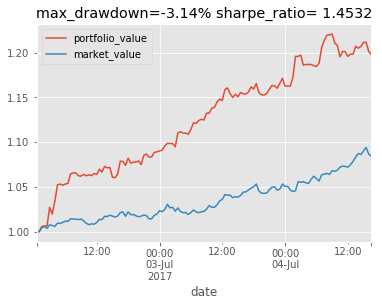

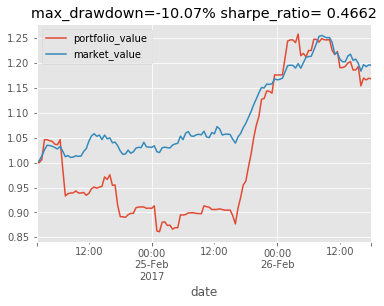

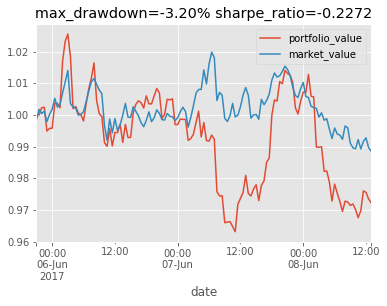

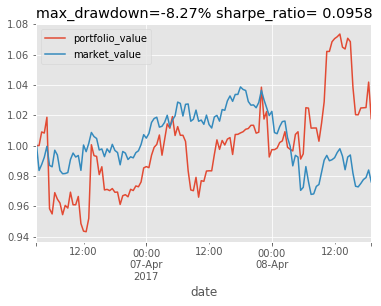

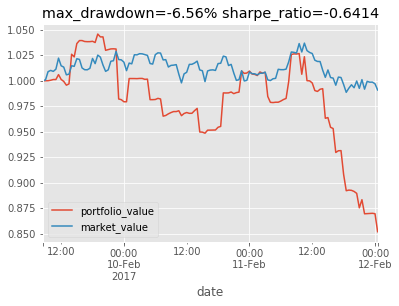

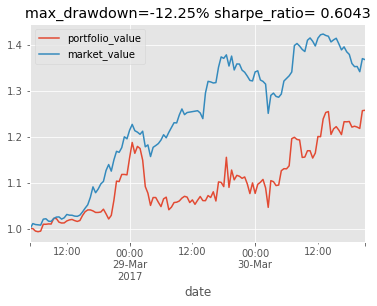

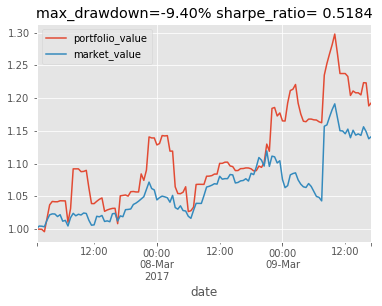

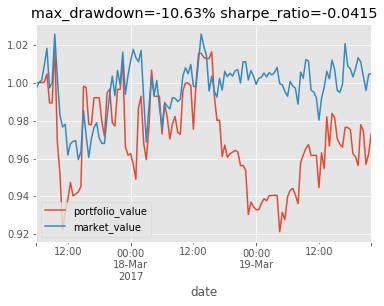

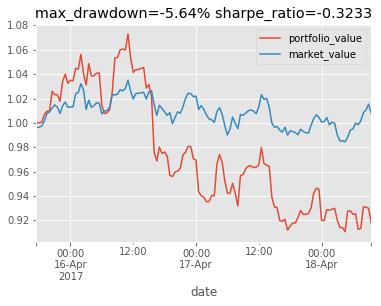

In [20]:
# env_test = env

# Test
for i in range(10):
    model.train(False)
    state = env_test.reset()
    for i in range(250):
        state = Variable(torch.Tensor(state).unsqueeze(0))
        mu, sigma_sq, v = model(state)
        eps = torch.randn(mu.size())
        action = (mu + sigma_sq.sqrt() * Variable(eps))
        env_action = action.data.squeeze().numpy()
        state, reward, done, info = env_test.step(env_action)
        if done:
            break

    env_test.plot()